In [ ]:
pip install scikit-plot

In [ ]:
import numpy as np
import pandas as pd
import os
import librosa
import json
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils.np_utils import to_categorical
import keras 
from keras.models import Sequential
from keras import optimizers
from keras.layers import Conv2D, Conv1D, Dense, Dropout, Flatten, AveragePooling2D, BatchNormalization, MaxPool2D, MaxPooling1D, Activation, MaxPooling2D, LSTM
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import scipy
from sklearn.model_selection import train_test_split
import scikitplot as skplt


In [ ]:
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/SPEECH_EMOTION_Recognition/datasets/archive/"

Modality = []
Vocal_channel = []
Emotion  = []
Emotional_intensity = []
Statement = []
Repetition = []
Actor = []
Paths = []

for i, (dirpath, dirnames, filenames) in enumerate(os.walk(DATA_PATH)):
  if dirpath is not DATA_PATH:
    for f in filenames:
      if '(1)' not in f: #eliminate coincidences
        file_path = os.path.join(dirpath, f)
        Paths.append(file_path)
        Modality.append(f.split('.')[0].split('-')[0])
        Vocal_channel.append(f.split('.')[0].split('-')[1])
        Emotion.append(f.split('.')[0].split('-')[2])
        Emotional_intensity.append(f.split('.')[0].split('-')[3])
        Statement.append(f.split('.')[0].split('-')[4])
        Repetition.append(f.split('.')[0].split('-')[5])
        Actor.append(int(f.split('.')[0].split('-')[6]))

Ravdess_DF = pd.DataFrame()
Ravdess_DF['Paths'] = Paths
Ravdess_DF['Modality'] = Modality
Ravdess_DF['Vocal_channel'] = Vocal_channel
Ravdess_DF['Emotion'] = Emotion
Ravdess_DF['Emotional_intensity'] = Emotional_intensity
Ravdess_DF['Statement'] = Statement
Ravdess_DF['Repetition'] = Repetition
Ravdess_DF['Actor'] = Actor

# mfcc_13 + basic model

In [ ]:
features = []
labels = []
for i in range(len(Ravdess_DF['Paths'])):
  if ((Ravdess_DF['Emotion'][i] == '03') | (Ravdess_DF['Emotion'][i] == '04') | 
      (Ravdess_DF['Emotion'][i] == '05') | (Ravdess_DF['Emotion'][i] == '06')):
    signal, sr = librosa.load(Ravdess_DF['Paths'][i])
    mfcc = np.mean(librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13).T,axis=0).tolist()
    features.append(mfcc)
    if Ravdess_DF['Emotion'][i] == '03':
      labels.append(0)
    elif Ravdess_DF['Emotion'][i] == '04':
      labels.append(1)
    elif Ravdess_DF['Emotion'][i] == '05':
      labels.append(2)
    elif Ravdess_DF['Emotion'][i] == '06':
      labels.append(3)


In [ ]:
X = features
y = labels

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

## basic models:

In [ ]:
model = Sequential()
model.add(Dense(13, input_shape=(13, ), activation = 'relu'))
#model.add(Dropout(0.1))
model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.25))
model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.2))
model.add(Dense(4, activation = 'softmax'))

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 13)                182       
_________________________________________________________________
dense_9 (Dense)              (None, 128)               1792      
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 516       
Total params: 19,002
Trainable params: 19,002
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, batch_size=64, epochs=200, 
                    validation_data=(X_val, y_val))

Epoch 1/200
10/10 [==============================] - 1s 37ms/step - loss: 29.4399 - accuracy: 0.2400 - val_loss: 9.8778 - val_accuracy: 0.2857
Epoch 2/200
10/10 [==============================] - 0s 5ms/step - loss: 8.0001 - accuracy: 0.2403 - val_loss: 5.2537 - val_accuracy: 0.2286
Epoch 3/200
10/10 [==============================] - 0s 4ms/step - loss: 4.2250 - accuracy: 0.2930 - val_loss: 2.5745 - val_accuracy: 0.2857
Epoch 4/200
10/10 [==============================] - 0s 4ms/step - loss: 2.2918 - accuracy: 0.2889 - val_loss: 1.5745 - val_accuracy: 0.1714
Epoch 5/200
10/10 [==============================] - 0s 4ms/step - loss: 1.7860 - accuracy: 0.2212 - val_loss: 1.5346 - val_accuracy: 0.1857
Epoch 6/200
10/10 [==============================] - 0s 5ms/step - loss: 1.6829 - accuracy: 0.2727 - val_loss: 1.4873 - val_accuracy: 0.2714
Epoch 7/200
10/10 [==============================] - 0s 5ms/step - loss: 1.5826 - accuracy: 0.3012 - val_loss: 1.5418 - val_accuracy: 0.2857
Epoch 8/200

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/SPEECH_EMOTION_Recognition/Nộp bài(chốt hạ)/model_saver/basic_mfcc13_ravdess.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.34      0.92      0.50        13
        fear       0.40      0.10      0.15        21
       happy       0.48      0.52      0.50        23
         sad       0.67      0.40      0.50        20

    accuracy                           0.44        77
   macro avg       0.47      0.49      0.41        77
weighted avg       0.48      0.44      0.41        77



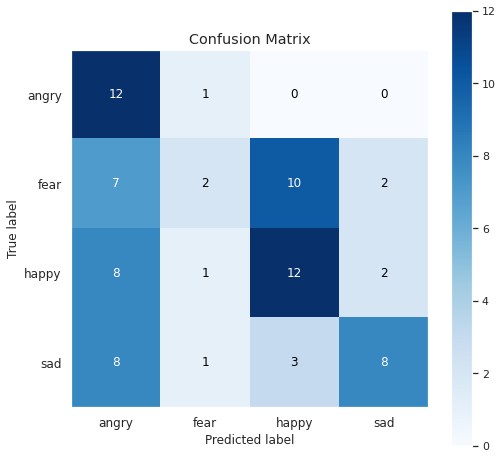

In [ ]:
skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))

# mfcc_26 + basic model

In [ ]:
features = []
labels = []
for i in range(len(Ravdess_DF['Paths'])):
  if ((Ravdess_DF['Emotion'][i] == '03') | (Ravdess_DF['Emotion'][i] == '04') | 
      (Ravdess_DF['Emotion'][i] == '05') | (Ravdess_DF['Emotion'][i] == '06')):
    signal, sr = librosa.load(Ravdess_DF['Paths'][i])
    mfcc = np.mean(librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=26).T,axis=0).tolist()
    features.append(mfcc)
    if Ravdess_DF['Emotion'][i] == '03':
      labels.append(0)
    elif Ravdess_DF['Emotion'][i] == '04':
      labels.append(1)
    elif Ravdess_DF['Emotion'][i] == '05':
      labels.append(2)
    elif Ravdess_DF['Emotion'][i] == '06':
      labels.append(3)


In [ ]:
X = features
y = labels

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

## basic models:

In [ ]:
model = Sequential()
model.add(Dense(26, input_shape=(26, ), activation = 'relu'))
#model.add(Dropout(0.1))
model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.25))
model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.2))
model.add(Dense(4, activation = 'softmax'))

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 26)                702       
_________________________________________________________________
dense_5 (Dense)              (None, 128)               3456      
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 516       
Total params: 21,186
Trainable params: 21,186
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, batch_size=64, epochs=200, 
                    validation_data=(X_val, y_val))

Epoch 1/200
10/10 [==============================] - 1s 36ms/step - loss: 12.2251 - accuracy: 0.2722 - val_loss: 7.2771 - val_accuracy: 0.2286
Epoch 2/200
10/10 [==============================] - 0s 4ms/step - loss: 5.3027 - accuracy: 0.2803 - val_loss: 2.1272 - val_accuracy: 0.2714
Epoch 3/200
10/10 [==============================] - 0s 4ms/step - loss: 2.0043 - accuracy: 0.3322 - val_loss: 2.1571 - val_accuracy: 0.2857
Epoch 4/200
10/10 [==============================] - 0s 4ms/step - loss: 1.7827 - accuracy: 0.2715 - val_loss: 1.8919 - val_accuracy: 0.1714
Epoch 5/200
10/10 [==============================] - 0s 4ms/step - loss: 1.5591 - accuracy: 0.3184 - val_loss: 1.7870 - val_accuracy: 0.2143
Epoch 6/200
10/10 [==============================] - 0s 5ms/step - loss: 1.5187 - accuracy: 0.3564 - val_loss: 1.7788 - val_accuracy: 0.2000
Epoch 7/200
10/10 [==============================] - 0s 4ms/step - loss: 1.4099 - accuracy: 0.3607 - val_loss: 1.6211 - val_accuracy: 0.2286
Epoch 8/200

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/SPEECH_EMOTION_Recognition/Nộp bài(chốt hạ)/model_saver/basic_mfcc26_ravdess.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.65      1.00      0.79        13
        fear       0.65      0.62      0.63        21
       happy       0.73      0.48      0.58        23
         sad       0.59      0.65      0.62        20

    accuracy                           0.65        77
   macro avg       0.66      0.69      0.66        77
weighted avg       0.66      0.65      0.64        77



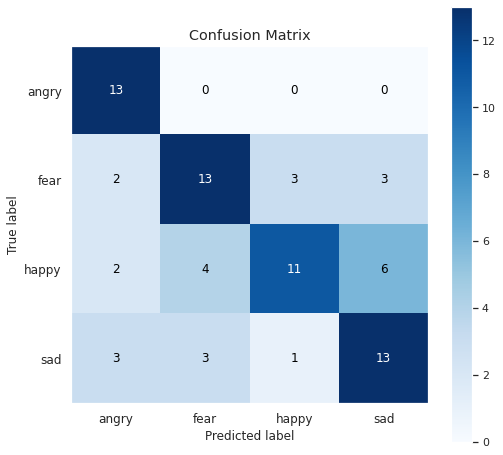

In [ ]:
skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))

# mfcc_39 + basic model

In [ ]:
features = []
labels = []
for i in range(len(Ravdess_DF['Paths'])):
  if ((Ravdess_DF['Emotion'][i] == '03') | (Ravdess_DF['Emotion'][i] == '04') | 
      (Ravdess_DF['Emotion'][i] == '05') | (Ravdess_DF['Emotion'][i] == '06')):
    signal, sr = librosa.load(Ravdess_DF['Paths'][i])
    mfcc = np.mean(librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=39).T,axis=0).tolist()
    features.append(mfcc)
    if Ravdess_DF['Emotion'][i] == '03':
      labels.append(0)
    elif Ravdess_DF['Emotion'][i] == '04':
      labels.append(1)
    elif Ravdess_DF['Emotion'][i] == '05':
      labels.append(2)
    elif Ravdess_DF['Emotion'][i] == '06':
      labels.append(3)


In [ ]:
X = features
y = labels

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

## basic models:

In [ ]:
model = Sequential()
model.add(Dense(39, input_shape=(39, ), activation = 'relu'))
#model.add(Dropout(0.1))
model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.25))
model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.2))
model.add(Dense(4, activation = 'softmax'))

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 39)                1560      
_________________________________________________________________
dense_13 (Dense)             (None, 128)               5120      
_________________________________________________________________
dense_14 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 516       
Total params: 23,708
Trainable params: 23,708
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, batch_size=64, epochs=200, 
                    validation_data=(X_val, y_val))

Epoch 1/200
10/10 [==============================] - 1s 36ms/step - loss: 13.3817 - accuracy: 0.2085 - val_loss: 4.6035 - val_accuracy: 0.2857
Epoch 2/200
10/10 [==============================] - 0s 4ms/step - loss: 4.8008 - accuracy: 0.2317 - val_loss: 1.9268 - val_accuracy: 0.3000
Epoch 3/200
10/10 [==============================] - 0s 5ms/step - loss: 2.3835 - accuracy: 0.2541 - val_loss: 1.9489 - val_accuracy: 0.3286
Epoch 4/200
10/10 [==============================] - 0s 4ms/step - loss: 2.0334 - accuracy: 0.2693 - val_loss: 1.5078 - val_accuracy: 0.3429
Epoch 5/200
10/10 [==============================] - 0s 4ms/step - loss: 1.6560 - accuracy: 0.3394 - val_loss: 1.4570 - val_accuracy: 0.3429
Epoch 6/200
10/10 [==============================] - 0s 6ms/step - loss: 1.3861 - accuracy: 0.3838 - val_loss: 1.6032 - val_accuracy: 0.4000
Epoch 7/200
10/10 [==============================] - 0s 4ms/step - loss: 1.5907 - accuracy: 0.3687 - val_loss: 1.5467 - val_accuracy: 0.4000
Epoch 8/200

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/SPEECH_EMOTION_Recognition/Nộp bài(chốt hạ)/model_saver/basic_mfcc39_ravdess.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.79      0.85      0.81        13
        fear       1.00      0.43      0.60        21
       happy       0.83      0.43      0.57        23
         sad       0.48      1.00      0.65        20

    accuracy                           0.65        77
   macro avg       0.77      0.68      0.66        77
weighted avg       0.78      0.65      0.64        77



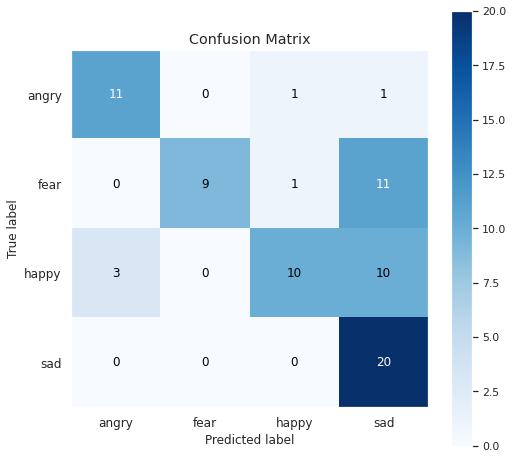

In [ ]:
skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))

# mfcc_13 + conv1D:

In [ ]:
audio_duration = 3
sampling_rate = 22050
input_length = sampling_rate * audio_duration

In [ ]:
features = []
labels = []
for i in range(len(Ravdess_DF['Paths'])):
  if ((Ravdess_DF['Emotion'][i] == '03') | (Ravdess_DF['Emotion'][i] == '04') | 
      (Ravdess_DF['Emotion'][i] == '05') | (Ravdess_DF['Emotion'][i] == '06')):
    signal, sr = librosa.load(Ravdess_DF['Paths'][i])

    if len(signal) > input_length:
      signal = signal[0:input_length]
    elif  input_length > len(signal):
      max_offset = input_length - len(signal)  
      signal = np.pad(signal, (0, max_offset), "constant")

    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13).T
    mfcc = mfcc.reshape(-1,1)
    features.append(mfcc)

    if Ravdess_DF['Emotion'][i] == '03':
      labels.append(0)
    elif Ravdess_DF['Emotion'][i] == '04':
      labels.append(1)
    elif Ravdess_DF['Emotion'][i] == '05':
      labels.append(2)
    elif Ravdess_DF['Emotion'][i] == '06':
      labels.append(3)


In [ ]:
X = features
y = labels

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape


((621, 1690, 1), (77, 1690, 1), (621, 4), (77, 4))

In [ ]:

# CNN I/P Config
num_classes = 4
input_shape = X_train.shape[1:]
learning_rate = 0.0001
decay = 1e-6
momentum = 0.9

#LSTM Configuration
num_lstm = 256

In [ ]:
model = Sequential(name='Audio_CNN_1D')

# LFLB1
model.add(Conv1D(filters=64, kernel_size=(3), strides=1, padding='same', data_format='channels_last',input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.5))

# LFLB2
model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LFLB3
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LFLB4
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LSTM
model.add(LSTM(units=num_lstm))

# FC
model.add(Dense(units=num_classes, activation='softmax'))

# Model compilation
opt= keras.optimizers.Adam(lr=0.01, beta_1=0.9,  beta_2=0.999, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()


Model: "Audio_CNN_1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1690, 64)          256       
_________________________________________________________________
batch_normalization (BatchNo (None, 1690, 64)          256       
_________________________________________________________________
activation (Activation)      (None, 1690, 64)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 422, 64)           0         
_________________________________________________________________
dropout (Dropout)            (None, 422, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 422, 64)           12352     
_________________________________________________________________
batch_normalization_1 (Batch (None, 422, 64)          

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#Train Config

batch_size = 16
num_epochs = 200

# Model Training
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('/content/Audio_1DCNN.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')
cnnhistory=model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs,validation_data=(X_val, y_val), callbacks=[mcp_save, lr_reduce])

Epoch 1/200
39/39 [==============================] - 18s 156ms/step - loss: 1.9610 - categorical_accuracy: 0.2953 - val_loss: 1.5584 - val_categorical_accuracy: 0.1857
Epoch 2/200
39/39 [==============================] - 5s 128ms/step - loss: 1.2561 - categorical_accuracy: 0.4271 - val_loss: 1.9221 - val_categorical_accuracy: 0.1857
Epoch 3/200
39/39 [==============================] - 5s 127ms/step - loss: 1.2181 - categorical_accuracy: 0.4612 - val_loss: 2.0510 - val_categorical_accuracy: 0.1857
Epoch 4/200
39/39 [==============================] - 5s 130ms/step - loss: 1.1965 - categorical_accuracy: 0.4731 - val_loss: 1.6126 - val_categorical_accuracy: 0.2429
Epoch 5/200
39/39 [==============================] - 5s 129ms/step - loss: 1.2549 - categorical_accuracy: 0.4062 - val_loss: 1.4981 - val_categorical_accuracy: 0.2286
Epoch 6/200
39/39 [==============================] - 5s 128ms/step - loss: 1.2130 - categorical_accuracy: 0.4402 - val_loss: 1.4579 - val_categorical_accuracy: 0.34

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/SPEECH_EMOTION_Recognition/Nộp bài(chốt hạ)/model_saver/conv1D_mfcc13_ravdess.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.73      0.85      0.79        13
        fear       0.75      0.57      0.65        21
       happy       0.64      0.70      0.67        23
         sad       0.76      0.80      0.78        20

    accuracy                           0.71        77
   macro avg       0.72      0.73      0.72        77
weighted avg       0.72      0.71      0.71        77



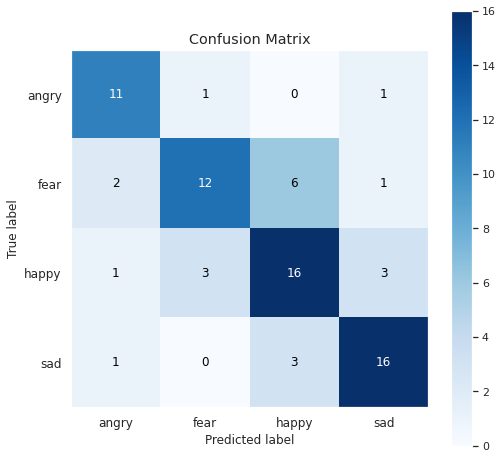

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))

###test_result on best weghts

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}

# Define a simple sequential model
def create_model():
  model = Sequential(name='Audio_CNN_1D')

  # LFLB1
  model.add(Conv1D(filters=64, kernel_size=(3), strides=1, padding='same', data_format='channels_last',input_shape=input_shape))
  model.add(BatchNormalization())
  model.add(Activation('elu'))
  model.add(MaxPooling1D(pool_size=4, strides=4))
  model.add(Dropout(0.5))

  # LFLB2
  model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('elu'))
  model.add(MaxPooling1D(pool_size=4, strides=4))
  model.add(Dropout(0.25))

  # LFLB3
  model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('elu'))
  model.add(MaxPooling1D(pool_size=4, strides=4))
  model.add(Dropout(0.25))

  # LFLB4
  model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('elu'))
  model.add(MaxPooling1D(pool_size=4, strides=4))
  model.add(Dropout(0.25))

  # LSTM
  model.add(LSTM(units=num_lstm))

  # FC
  model.add(Dense(units=num_classes, activation='softmax'))

  # Model compilation
  opt= keras.optimizers.Adam(lr=0.01, beta_1=0.9,  beta_2=0.999, amsgrad=False)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

  return model

# Create a basic model instance
model = create_model()
# Loads the weights
model.load_weights('/content/Audio_1DCNN.h5')

Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


              precision    recall  f1-score   support

       angry       0.69      0.69      0.69        13
        fear       0.75      0.57      0.65        21
       happy       0.55      0.70      0.62        23
         sad       0.74      0.70      0.72        20

    accuracy                           0.66        77
   macro avg       0.68      0.66      0.67        77
weighted avg       0.68      0.66      0.66        77



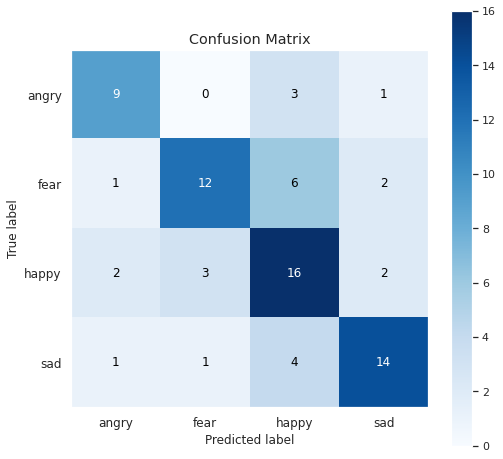

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))

# mfcc_26 + conv1D:

In [ ]:
audio_duration = 3
sampling_rate = 22050
input_length = sampling_rate * audio_duration

In [ ]:
features = []
labels = []
for i in range(len(Ravdess_DF['Paths'])):
  if ((Ravdess_DF['Emotion'][i] == '03') | (Ravdess_DF['Emotion'][i] == '04') | 
      (Ravdess_DF['Emotion'][i] == '05') | (Ravdess_DF['Emotion'][i] == '06')):
    signal, sr = librosa.load(Ravdess_DF['Paths'][i])

    if len(signal) > input_length:
      signal = signal[0:input_length]
    elif  input_length > len(signal):
      max_offset = input_length - len(signal)  
      signal = np.pad(signal, (0, max_offset), "constant")

    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=26).T
    mfcc = mfcc.reshape(-1,1)
    features.append(mfcc)

    if Ravdess_DF['Emotion'][i] == '03':
      labels.append(0)
    elif Ravdess_DF['Emotion'][i] == '04':
      labels.append(1)
    elif Ravdess_DF['Emotion'][i] == '05':
      labels.append(2)
    elif Ravdess_DF['Emotion'][i] == '06':
      labels.append(3)


In [ ]:
X = features
y = labels

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape


((621, 3380, 1), (77, 3380, 1), (621, 4), (77, 4))

In [ ]:

# CNN I/P Config
num_classes = 4
input_shape = X_train.shape[1:]
learning_rate = 0.0001
decay = 1e-6
momentum = 0.9

#LSTM Configuration
num_lstm = 256

In [ ]:
model = Sequential(name='Audio_CNN_1D')

# LFLB1
model.add(Conv1D(filters=64, kernel_size=(3), strides=1, padding='same', data_format='channels_last',input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.5))

# LFLB2
model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LFLB3
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LFLB4
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LSTM
model.add(LSTM(units=num_lstm))

# FC
model.add(Dense(units=num_classes, activation='softmax'))

# Model compilation
opt= keras.optimizers.Adam(lr=0.01, beta_1=0.9,  beta_2=0.999, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()


Model: "Audio_CNN_1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 3380, 64)          256       
_________________________________________________________________
batch_normalization_16 (Batc (None, 3380, 64)          256       
_________________________________________________________________
activation_16 (Activation)   (None, 3380, 64)          0         
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 845, 64)           0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 845, 64)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 845, 64)           12352     
_________________________________________________________________
batch_normalization_17 (Batc (None, 845, 64)          

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#Train Config

batch_size = 16
num_epochs = 200

# Model Training
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('/content/Audio_1DCNN.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')
cnnhistory=model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs,validation_data=(X_val, y_val), callbacks=[mcp_save, lr_reduce])

Epoch 1/200
39/39 [==============================] - 15s 274ms/step - loss: 1.9676 - categorical_accuracy: 0.3488 - val_loss: 1.6166 - val_categorical_accuracy: 0.1857
Epoch 2/200
39/39 [==============================] - 10s 245ms/step - loss: 1.2756 - categorical_accuracy: 0.4107 - val_loss: 1.5244 - val_categorical_accuracy: 0.1857
Epoch 3/200
39/39 [==============================] - 9s 240ms/step - loss: 1.2569 - categorical_accuracy: 0.4111 - val_loss: 1.7697 - val_categorical_accuracy: 0.1857
Epoch 4/200
39/39 [==============================] - 9s 239ms/step - loss: 1.2512 - categorical_accuracy: 0.4100 - val_loss: 2.0437 - val_categorical_accuracy: 0.1857
Epoch 5/200
39/39 [==============================] - 9s 242ms/step - loss: 1.1861 - categorical_accuracy: 0.4686 - val_loss: 1.9157 - val_categorical_accuracy: 0.1857
Epoch 6/200
39/39 [==============================] - 9s 243ms/step - loss: 1.2061 - categorical_accuracy: 0.4108 - val_loss: 1.9692 - val_categorical_accuracy: 0.2

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/SPEECH_EMOTION_Recognition/Nộp bài(chốt hạ)/model_saver/conv1D_mfcc26_ravdess.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.69      0.85      0.76        13
        fear       0.65      0.52      0.58        21
       happy       0.71      0.52      0.60        23
         sad       0.63      0.85      0.72        20

    accuracy                           0.66        77
   macro avg       0.67      0.69      0.67        77
weighted avg       0.67      0.66      0.65        77



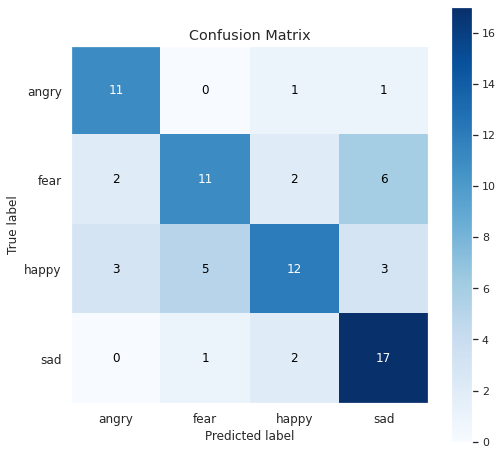

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))

# mfcc_39 + conv1D:

In [ ]:
audio_duration = 3
sampling_rate = 22050
input_length = sampling_rate * audio_duration

In [ ]:
features = []
labels = []
for i in range(len(Ravdess_DF['Paths'])):
  if ((Ravdess_DF['Emotion'][i] == '03') | (Ravdess_DF['Emotion'][i] == '04') | 
      (Ravdess_DF['Emotion'][i] == '05') | (Ravdess_DF['Emotion'][i] == '06')):
    signal, sr = librosa.load(Ravdess_DF['Paths'][i])

    if len(signal) > input_length:
      signal = signal[0:input_length]
    elif  input_length > len(signal):
      max_offset = input_length - len(signal)  
      signal = np.pad(signal, (0, max_offset), "constant")

    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=39).T
    mfcc = mfcc.reshape(-1,1)
    features.append(mfcc)

    if Ravdess_DF['Emotion'][i] == '03':
      labels.append(0)
    elif Ravdess_DF['Emotion'][i] == '04':
      labels.append(1)
    elif Ravdess_DF['Emotion'][i] == '05':
      labels.append(2)
    elif Ravdess_DF['Emotion'][i] == '06':
      labels.append(3)


In [ ]:
X = features
y = labels

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape


((621, 5070, 1), (77, 5070, 1), (621, 4), (77, 4))

In [ ]:

# CNN I/P Config
num_classes = 4
input_shape = X_train.shape[1:]
learning_rate = 0.0001
decay = 1e-6
momentum = 0.9

#LSTM Configuration
num_lstm = 256

In [ ]:
model = Sequential(name='Audio_CNN_1D')

# LFLB1
model.add(Conv1D(filters=64, kernel_size=(3), strides=1, padding='same', data_format='channels_last',input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.5))

# LFLB2
model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LFLB3
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LFLB4
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LSTM
model.add(LSTM(units=num_lstm))

# FC
model.add(Dense(units=num_classes, activation='softmax'))

# Model compilation
opt= keras.optimizers.Adam(lr=0.01, beta_1=0.9,  beta_2=0.999, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()


Model: "Audio_CNN_1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 5070, 64)          256       
_________________________________________________________________
batch_normalization (BatchNo (None, 5070, 64)          256       
_________________________________________________________________
activation (Activation)      (None, 5070, 64)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1267, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 1267, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1267, 64)          12352     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1267, 64)         

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#Train Config

batch_size = 16
num_epochs = 200

# Model Training
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('/content/Audio_1DCNN.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')
cnnhistory=model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs,validation_data=(X_val, y_val), callbacks=[mcp_save, lr_reduce])

Epoch 1/200
39/39 [==============================] - 53s 59ms/step - loss: 1.7661 - categorical_accuracy: 0.2848 - val_loss: 1.8292 - val_categorical_accuracy: 0.1857
Epoch 2/200
39/39 [==============================] - 1s 15ms/step - loss: 1.2470 - categorical_accuracy: 0.4363 - val_loss: 1.7030 - val_categorical_accuracy: 0.1857
Epoch 3/200
39/39 [==============================] - 1s 15ms/step - loss: 1.2459 - categorical_accuracy: 0.4695 - val_loss: 1.4212 - val_categorical_accuracy: 0.1857
Epoch 4/200
39/39 [==============================] - 1s 15ms/step - loss: 1.2839 - categorical_accuracy: 0.4119 - val_loss: 1.5534 - val_categorical_accuracy: 0.2143
Epoch 5/200
39/39 [==============================] - 1s 15ms/step - loss: 1.2580 - categorical_accuracy: 0.4143 - val_loss: 1.7295 - val_categorical_accuracy: 0.1857
Epoch 6/200
39/39 [==============================] - 1s 16ms/step - loss: 1.2649 - categorical_accuracy: 0.3794 - val_loss: 1.9163 - val_categorical_accuracy: 0.2286
Epo

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/SPEECH_EMOTION_Recognition/Nộp bài(chốt hạ)/model_saver/conv1D_mfcc39_ravdess.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.75      0.69      0.72        13
        fear       0.58      0.67      0.62        21
       happy       0.65      0.48      0.55        23
         sad       0.67      0.80      0.73        20

    accuracy                           0.65        77
   macro avg       0.66      0.66      0.65        77
weighted avg       0.65      0.65      0.64        77



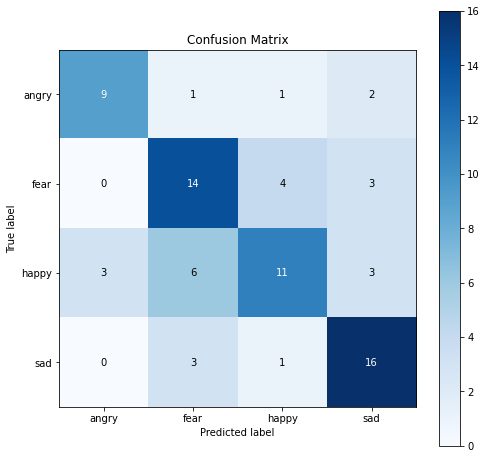

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))

# mfcc_13 + conv2D:

In [ ]:
audio_duration = 3
sampling_rate = 22050
input_length = sampling_rate * audio_duration

In [ ]:
features = []
labels = []
for i in range(len(Ravdess_DF['Paths'])):
  if ((Ravdess_DF['Emotion'][i] == '03') | (Ravdess_DF['Emotion'][i] == '04') | 
      (Ravdess_DF['Emotion'][i] == '05') | (Ravdess_DF['Emotion'][i] == '06')):
    signal, sr = librosa.load(Ravdess_DF['Paths'][i])

    if len(signal) > input_length:
      signal = signal[0:input_length]
    elif  input_length > len(signal):
      max_offset = input_length - len(signal)  
      signal = np.pad(signal, (0, max_offset), "constant")

    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13).T
    mfcc = np.expand_dims(mfcc, axis=-1)
    features.append(mfcc)

    if Ravdess_DF['Emotion'][i] == '03':
      labels.append(0)
    elif Ravdess_DF['Emotion'][i] == '04':
      labels.append(1)
    elif Ravdess_DF['Emotion'][i] == '05':
      labels.append(2)
    elif Ravdess_DF['Emotion'][i] == '06':
      labels.append(3)


In [ ]:
X = features
y = labels

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape


((621, 130, 13, 1), (77, 130, 13, 1), (621, 4), (77, 4))

In [ ]:
# CNN I/P Config
num_classes = 4
input_shape = X_train.shape[1:]
learning_rate = 0.0001
decay = 1e-6
momentum = 0.9

In [ ]:
model = Sequential(name='Audio_CNN_2D')

# LFLB1
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same',input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4,4), strides=(4,4)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(units=num_classes, activation='softmax'))

# Model compilation
opt = optimizers.SGD(lr=learning_rate, decay=decay, momentum=momentum, nesterov=True)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()

Model: "Audio_CNN_2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 130, 13, 64)       640       
_________________________________________________________________
batch_normalization_4 (Batch (None, 130, 13, 64)       256       
_________________________________________________________________
activation_4 (Activation)    (None, 130, 13, 64)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 6, 64)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 65, 6, 64)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 65, 6, 64)         36928     
_________________________________________________________________
batch_normalization_5 (Batch (None, 65, 6, 64)        

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#Train Config

batch_size = 16
num_epochs = 200

# Model Training
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('/content/Modelfull_2_1.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')
cnnhistory=model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs,validation_data=(X_val, y_val), callbacks=[mcp_save, lr_reduce])

Epoch 1/200
39/39 [==============================] - 3s 20ms/step - loss: 2.7719 - categorical_accuracy: 0.2917 - val_loss: 2.0664 - val_categorical_accuracy: 0.2571
Epoch 2/200
39/39 [==============================] - 0s 4ms/step - loss: 2.2485 - categorical_accuracy: 0.3436 - val_loss: 1.5513 - val_categorical_accuracy: 0.2714
Epoch 3/200
39/39 [==============================] - 0s 4ms/step - loss: 2.2768 - categorical_accuracy: 0.3220 - val_loss: 1.4574 - val_categorical_accuracy: 0.3429
Epoch 4/200
39/39 [==============================] - 0s 5ms/step - loss: 2.0994 - categorical_accuracy: 0.3549 - val_loss: 1.3980 - val_categorical_accuracy: 0.3000
Epoch 5/200
39/39 [==============================] - 0s 4ms/step - loss: 2.0014 - categorical_accuracy: 0.3190 - val_loss: 1.3988 - val_categorical_accuracy: 0.3143
Epoch 6/200
39/39 [==============================] - 0s 5ms/step - loss: 1.9409 - categorical_accuracy: 0.3190 - val_loss: 1.3968 - val_categorical_accuracy: 0.3857
Epoch 7/2

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/SPEECH_EMOTION_Recognition/Nộp bài(chốt hạ)/model_saver/conv2D_mfcc13_ravdess.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.60      0.92      0.73        13
        fear       0.65      0.52      0.58        21
       happy       0.56      0.61      0.58        23
         sad       0.80      0.60      0.69        20

    accuracy                           0.64        77
   macro avg       0.65      0.66      0.64        77
weighted avg       0.65      0.64      0.63        77



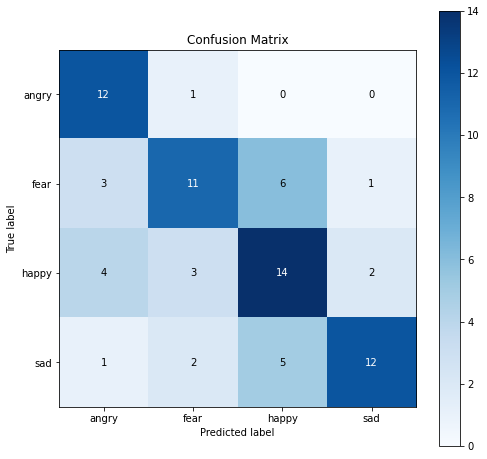

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))

# mfcc_26 + conv2D:

In [ ]:
audio_duration = 3
sampling_rate = 22050
input_length = sampling_rate * audio_duration

In [ ]:
features = []
labels = []
for i in range(len(Ravdess_DF['Paths'])):
  if ((Ravdess_DF['Emotion'][i] == '03') | (Ravdess_DF['Emotion'][i] == '04') | 
      (Ravdess_DF['Emotion'][i] == '05') | (Ravdess_DF['Emotion'][i] == '06')):
    signal, sr = librosa.load(Ravdess_DF['Paths'][i])

    if len(signal) > input_length:
      signal = signal[0:input_length]
    elif  input_length > len(signal):
      max_offset = input_length - len(signal)  
      signal = np.pad(signal, (0, max_offset), "constant")

    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=26).T
    mfcc = np.expand_dims(mfcc, axis=-1)
    features.append(mfcc)

    if Ravdess_DF['Emotion'][i] == '03':
      labels.append(0)
    elif Ravdess_DF['Emotion'][i] == '04':
      labels.append(1)
    elif Ravdess_DF['Emotion'][i] == '05':
      labels.append(2)
    elif Ravdess_DF['Emotion'][i] == '06':
      labels.append(3)


In [ ]:
X = features
y = labels

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape


((621, 130, 26, 1), (77, 130, 26, 1), (621, 4), (77, 4))

In [ ]:
# CNN I/P Config
num_classes = 4
input_shape = X_train.shape[1:]
learning_rate = 0.0001
decay = 1e-6
momentum = 0.9

In [ ]:
model = Sequential(name='Audio_CNN_2D')

# LFLB1
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same',input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4,4), strides=(4,4)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(units=num_classes, activation='softmax'))

# Model compilation
opt = optimizers.SGD(lr=learning_rate, decay=decay, momentum=momentum, nesterov=True)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()

Model: "Audio_CNN_2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 130, 26, 64)       640       
_________________________________________________________________
batch_normalization_6 (Batch (None, 130, 26, 64)       256       
_________________________________________________________________
activation_6 (Activation)    (None, 130, 26, 64)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 65, 13, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 65, 13, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 65, 13, 64)        36928     
_________________________________________________________________
batch_normalization_7 (Batch (None, 65, 13, 64)       

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#Train Config

batch_size = 16
num_epochs = 200

# Model Training
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('/content/Modelfull_2_1.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')
cnnhistory=model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs,validation_data=(X_val, y_val), callbacks=[mcp_save, lr_reduce])

Epoch 1/200
39/39 [==============================] - 2s 23ms/step - loss: 2.8076 - categorical_accuracy: 0.1992 - val_loss: 2.1010 - val_categorical_accuracy: 0.2857
Epoch 2/200
39/39 [==============================] - 0s 6ms/step - loss: 2.3760 - categorical_accuracy: 0.2491 - val_loss: 1.5884 - val_categorical_accuracy: 0.3571
Epoch 3/200
39/39 [==============================] - 0s 6ms/step - loss: 2.2413 - categorical_accuracy: 0.2967 - val_loss: 1.6176 - val_categorical_accuracy: 0.2286
Epoch 4/200
39/39 [==============================] - 0s 6ms/step - loss: 1.9773 - categorical_accuracy: 0.3331 - val_loss: 1.4811 - val_categorical_accuracy: 0.3714
Epoch 5/200
39/39 [==============================] - 0s 6ms/step - loss: 1.7594 - categorical_accuracy: 0.3317 - val_loss: 1.5699 - val_categorical_accuracy: 0.3429
Epoch 6/200
39/39 [==============================] - 0s 6ms/step - loss: 1.6477 - categorical_accuracy: 0.4146 - val_loss: 1.3922 - val_categorical_accuracy: 0.4571
Epoch 7/2

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/SPEECH_EMOTION_Recognition/Nộp bài(chốt hạ)/model_saver/conv2D_mfcc26_ravdess.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.79      0.85      0.81        13
        fear       0.64      0.33      0.44        21
       happy       0.51      0.78      0.62        23
         sad       0.76      0.65      0.70        20

    accuracy                           0.64        77
   macro avg       0.68      0.65      0.64        77
weighted avg       0.66      0.64      0.62        77



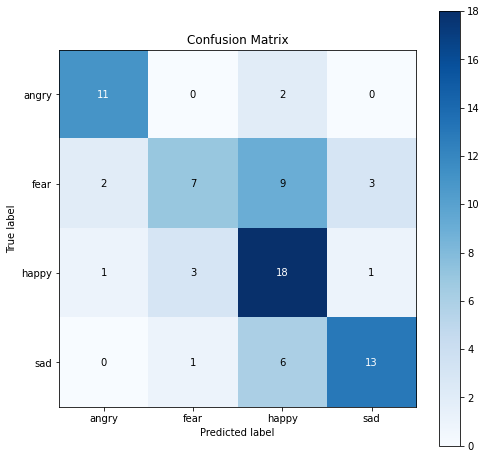

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))

# mfcc_39 + conv2D:

In [ ]:
audio_duration = 3
sampling_rate = 22050
input_length = sampling_rate * audio_duration

In [ ]:
features = []
labels = []
for i in range(len(Ravdess_DF['Paths'])):
  if ((Ravdess_DF['Emotion'][i] == '03') | (Ravdess_DF['Emotion'][i] == '04') | 
      (Ravdess_DF['Emotion'][i] == '05') | (Ravdess_DF['Emotion'][i] == '06')):
    signal, sr = librosa.load(Ravdess_DF['Paths'][i])

    if len(signal) > input_length:
      signal = signal[0:input_length]
    elif  input_length > len(signal):
      max_offset = input_length - len(signal)  
      signal = np.pad(signal, (0, max_offset), "constant")

    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=39).T
    mfcc = np.expand_dims(mfcc, axis=-1)
    features.append(mfcc)

    if Ravdess_DF['Emotion'][i] == '03':
      labels.append(0)
    elif Ravdess_DF['Emotion'][i] == '04':
      labels.append(1)
    elif Ravdess_DF['Emotion'][i] == '05':
      labels.append(2)
    elif Ravdess_DF['Emotion'][i] == '06':
      labels.append(3)


In [ ]:
X = features
y = labels

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape


((621, 130, 39, 1), (77, 130, 39, 1), (621, 4), (77, 4))

In [ ]:
# CNN I/P Config
num_classes = 4
input_shape = X_train.shape[1:]
learning_rate = 0.0001
decay = 1e-6
momentum = 0.9

In [ ]:
model = Sequential(name='Audio_CNN_2D')

# LFLB1
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same',input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4,4), strides=(4,4)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(units=num_classes, activation='softmax'))

# Model compilation
opt = optimizers.SGD(lr=learning_rate, decay=decay, momentum=momentum, nesterov=True)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()

Model: "Audio_CNN_2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 130, 39, 64)       640       
_________________________________________________________________
batch_normalization_10 (Batc (None, 130, 39, 64)       256       
_________________________________________________________________
activation_10 (Activation)   (None, 130, 39, 64)       0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 65, 19, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 65, 19, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 65, 19, 64)        36928     
_________________________________________________________________
batch_normalization_11 (Batc (None, 65, 19, 64)       

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#Train Config

batch_size = 16
num_epochs = 200

# Model Training
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('/content/Modelfull_2_1.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')
cnnhistory=model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs,validation_data=(X_val, y_val), callbacks=[mcp_save, lr_reduce])

Epoch 1/200
39/39 [==============================] - 2s 18ms/step - loss: 2.7248 - categorical_accuracy: 0.2233 - val_loss: 2.6544 - val_categorical_accuracy: 0.2143
Epoch 2/200
39/39 [==============================] - 0s 8ms/step - loss: 2.3506 - categorical_accuracy: 0.2743 - val_loss: 2.2641 - val_categorical_accuracy: 0.2000
Epoch 3/200
39/39 [==============================] - 0s 7ms/step - loss: 1.9715 - categorical_accuracy: 0.3386 - val_loss: 1.7578 - val_categorical_accuracy: 0.2286
Epoch 4/200
39/39 [==============================] - 0s 7ms/step - loss: 1.9496 - categorical_accuracy: 0.3397 - val_loss: 1.5218 - val_categorical_accuracy: 0.3286
Epoch 5/200
39/39 [==============================] - 0s 8ms/step - loss: 1.7655 - categorical_accuracy: 0.3853 - val_loss: 1.4678 - val_categorical_accuracy: 0.3571
Epoch 6/200
39/39 [==============================] - 0s 7ms/step - loss: 1.7080 - categorical_accuracy: 0.4155 - val_loss: 1.5234 - val_categorical_accuracy: 0.3000
Epoch 7/2

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/SPEECH_EMOTION_Recognition/Nộp bài(chốt hạ)/model_saver/conv2D_mfcc39_ravdess.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.69      0.85      0.76        13
        fear       0.92      0.52      0.67        21
       happy       0.74      0.61      0.67        23
         sad       0.63      0.95      0.76        20

    accuracy                           0.71        77
   macro avg       0.74      0.73      0.71        77
weighted avg       0.75      0.71      0.71        77



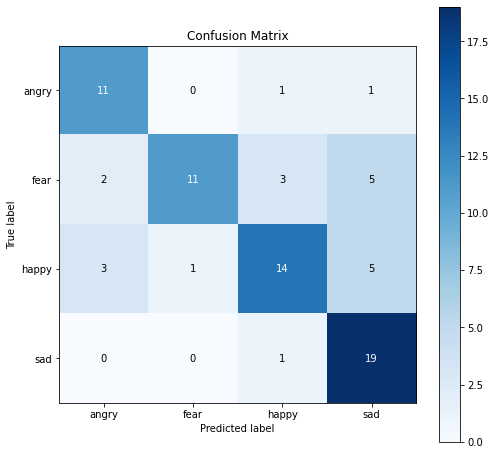

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))

# Mel Spectrogram + basic model

In [ ]:
audio_duration = 3
sampling_rate = 44100
input_length = sampling_rate * audio_duration


In [ ]:
features = []
labels = []
for i in range(len(Ravdess_DF['Paths'])):
  if ((Ravdess_DF['Emotion'][i] == '03') | (Ravdess_DF['Emotion'][i] == '04') | 
      (Ravdess_DF['Emotion'][i] == '05') | (Ravdess_DF['Emotion'][i] == '06')):
    signal, sample_rate = librosa.load(Ravdess_DF['Paths'][i], res_type='kaiser_fast',sr=22050*2)
    signal,index = librosa.effects.trim(signal,top_db = 25)
    signal = scipy.signal.wiener(signal)

    if len(signal) > input_length:
      signal = signal[0:input_length]
    elif  input_length > len(signal):
      max_offset = input_length - len(signal)  
      signal = np.pad(signal, (0, max_offset), "constant")

    melspec = librosa.feature.melspectrogram(signal, sr=sample_rate, n_mels=128,n_fft=2048,hop_length=512)   
    melspec = np.mean(melspec, axis=0)
    features.append(melspec)

    if Ravdess_DF['Emotion'][i] == '03':
      labels.append(0)
    elif Ravdess_DF['Emotion'][i] == '04':
      labels.append(1)
    elif Ravdess_DF['Emotion'][i] == '05':
      labels.append(2)
    elif Ravdess_DF['Emotion'][i] == '06':
      labels.append(3)

/usr/local/lib/python3.7/dist-packages/scipy/signal/signaltools.py:1456: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
/usr/local/lib/python3.7/dist-packages/scipy/signal/signaltools.py:1456: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


In [ ]:
X = features
y = labels

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [ ]:
X_train.shape

(621, 259)

## basic models:

In [ ]:
model = Sequential()
model.add(Dense(259, input_shape=(259, ), activation = 'relu'))
#model.add(Dropout(0.1))
model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.25))
model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.2))
model.add(Dense(4, activation = 'softmax'))

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 259)               67340     
_________________________________________________________________
dense_22 (Dense)             (None, 128)               33280     
_________________________________________________________________
dense_23 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_24 (Dense)             (None, 4)                 516       
Total params: 117,648
Trainable params: 117,648
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, batch_size=64, epochs=200, 
                    validation_data=(X_val, y_val))

Epoch 1/200
10/10 [==============================] - 1s 35ms/step - loss: 1.3433 - accuracy: 0.3353 - val_loss: 1.2123 - val_accuracy: 0.5000
Epoch 2/200
10/10 [==============================] - 0s 4ms/step - loss: 1.2082 - accuracy: 0.5057 - val_loss: 1.2295 - val_accuracy: 0.3857
Epoch 3/200
10/10 [==============================] - 0s 4ms/step - loss: 1.1362 - accuracy: 0.5164 - val_loss: 1.1985 - val_accuracy: 0.3714
Epoch 4/200
10/10 [==============================] - 0s 4ms/step - loss: 1.0913 - accuracy: 0.5188 - val_loss: 1.1887 - val_accuracy: 0.4000
Epoch 5/200
10/10 [==============================] - 0s 5ms/step - loss: 1.0251 - accuracy: 0.5992 - val_loss: 1.1652 - val_accuracy: 0.4286
Epoch 6/200
10/10 [==============================] - 0s 5ms/step - loss: 0.9752 - accuracy: 0.6090 - val_loss: 1.1568 - val_accuracy: 0.4143
Epoch 7/200
10/10 [==============================] - 0s 5ms/step - loss: 0.9318 - accuracy: 0.6123 - val_loss: 1.1591 - val_accuracy: 0.4286
Epoch 8/200


In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/SPEECH_EMOTION_Recognition/Nộp bài(chốt hạ)/model_saver/basic_melspec_ravdess.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.60      0.69      0.64        13
        fear       0.38      0.38      0.38        21
       happy       0.33      0.30      0.32        23
         sad       0.60      0.60      0.60        20

    accuracy                           0.47        77
   macro avg       0.48      0.49      0.49        77
weighted avg       0.46      0.47      0.46        77



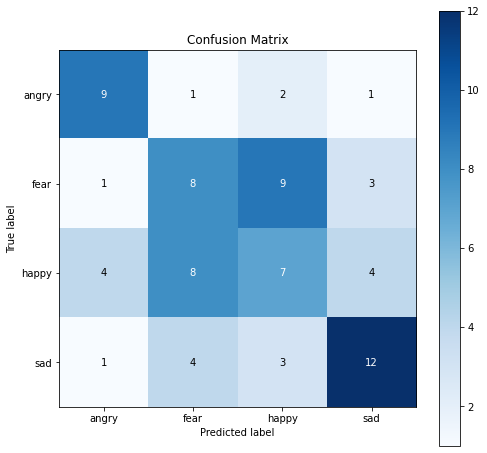

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))

# Mel Spectrogram + conv1D

In [ ]:
audio_duration = 3
sampling_rate = 44100
input_length = sampling_rate * audio_duration


In [ ]:
features = []
labels = []
for i in range(len(Ravdess_DF['Paths'])):
  if ((Ravdess_DF['Emotion'][i] == '03') | (Ravdess_DF['Emotion'][i] == '04') | 
      (Ravdess_DF['Emotion'][i] == '05') | (Ravdess_DF['Emotion'][i] == '06')):
    signal, sample_rate = librosa.load(Ravdess_DF['Paths'][i], res_type='kaiser_fast',sr=22050*2)
    signal,index = librosa.effects.trim(signal,top_db = 25)
    signal = scipy.signal.wiener(signal)

    if len(signal) > input_length:
      signal = signal[0:input_length]
    elif  input_length > len(signal):
      max_offset = input_length - len(signal)  
      signal = np.pad(signal, (0, max_offset), "constant")

    melspec = librosa.feature.melspectrogram(signal, sr=sample_rate, n_mels=128,n_fft=2048,hop_length=512)   
    melspec = melspec.reshape(-1,1)
    features.append(melspec)

    if Ravdess_DF['Emotion'][i] == '03':
      labels.append(0)
    elif Ravdess_DF['Emotion'][i] == '04':
      labels.append(1)
    elif Ravdess_DF['Emotion'][i] == '05':
      labels.append(2)
    elif Ravdess_DF['Emotion'][i] == '06':
      labels.append(3)

/usr/local/lib/python3.7/dist-packages/scipy/signal/signaltools.py:1456: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
/usr/local/lib/python3.7/dist-packages/scipy/signal/signaltools.py:1456: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


In [ ]:
X = features
y = labels

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((621, 33152, 1), (77, 33152, 1), (621, 4), (77, 4))

### conv1D

In [ ]:

# CNN I/P Config
num_classes = 4
input_shape = X_train.shape[1:]
learning_rate = 0.0001
decay = 1e-6
momentum = 0.9

#LSTM Configuration
num_lstm = 256

In [ ]:
model = Sequential(name='Audio_CNN_1D')

# LFLB1
model.add(Conv1D(filters=64, kernel_size=(3), strides=1, padding='same', data_format='channels_last',input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.5))

# LFLB2
model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LFLB3
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LFLB4
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LSTM
model.add(LSTM(units=num_lstm))

# FC
model.add(Dense(units=num_classes, activation='softmax'))

# Model compilation
opt= keras.optimizers.Adam(lr=0.01, beta_1=0.9,  beta_2=0.999, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()


Model: "Audio_CNN_1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 33152, 64)         256       
_________________________________________________________________
batch_normalization (BatchNo (None, 33152, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 33152, 64)         0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 8288, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 8288, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8288, 64)          12352     
_________________________________________________________________
batch_normalization_1 (Batch (None, 8288, 64)         

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#Train Config

batch_size = 16
num_epochs = 200

# Model Training
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('/content/Audio_1DCNN.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')
cnnhistory=model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs,validation_data=(X_val, y_val), callbacks=[mcp_save, lr_reduce])

Epoch 1/200
39/39 [==============================] - 54s 106ms/step - loss: 1.4787 - categorical_accuracy: 0.2359 - val_loss: 1.3743 - val_categorical_accuracy: 0.2571
Epoch 2/200
39/39 [==============================] - 3s 74ms/step - loss: 1.4794 - categorical_accuracy: 0.2432 - val_loss: 1.4252 - val_categorical_accuracy: 0.2286
Epoch 3/200
39/39 [==============================] - 3s 74ms/step - loss: 1.4068 - categorical_accuracy: 0.2697 - val_loss: 1.3865 - val_categorical_accuracy: 0.2143
Epoch 4/200
39/39 [==============================] - 3s 74ms/step - loss: 1.3898 - categorical_accuracy: 0.2677 - val_loss: 1.3695 - val_categorical_accuracy: 0.3143
Epoch 5/200
39/39 [==============================] - 3s 74ms/step - loss: 1.3950 - categorical_accuracy: 0.2629 - val_loss: 1.3826 - val_categorical_accuracy: 0.2143
Epoch 6/200
39/39 [==============================] - 3s 74ms/step - loss: 1.3835 - categorical_accuracy: 0.2722 - val_loss: 1.3546 - val_categorical_accuracy: 0.3143
Ep

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/SPEECH_EMOTION_Recognition/Nộp bài(chốt hạ)/model_saver/conv1D_melspec_ravdess.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.45      0.38      0.42        13
        fear       0.33      0.24      0.28        21
       happy       0.50      0.39      0.44        23
         sad       0.45      0.75      0.57        20

    accuracy                           0.44        77
   macro avg       0.44      0.44      0.42        77
weighted avg       0.44      0.44      0.42        77



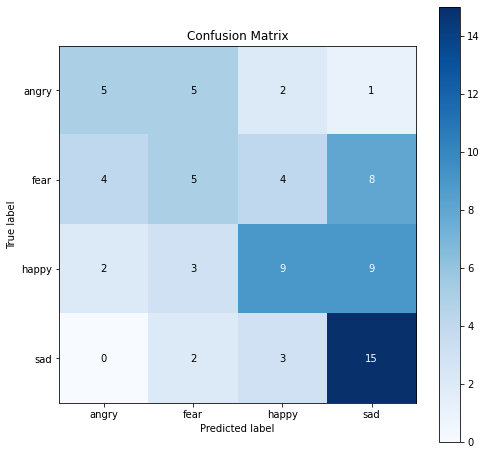

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))

# Mel Spectrogram + conv2D:

In [ ]:
audio_duration = 3
sampling_rate = 44100
input_length = sampling_rate * audio_duration


In [ ]:
features = []
labels = []
for i in range(len(Ravdess_DF['Paths'])):
  if ((Ravdess_DF['Emotion'][i] == '03') | (Ravdess_DF['Emotion'][i] == '04') | 
      (Ravdess_DF['Emotion'][i] == '05') | (Ravdess_DF['Emotion'][i] == '06')):
    signal, sample_rate = librosa.load(Ravdess_DF['Paths'][i], res_type='kaiser_fast',sr=22050*2)
    signal,index = librosa.effects.trim(signal,top_db = 25)
    signal = scipy.signal.wiener(signal)

    if len(signal) > input_length:
      signal = signal[0:input_length]
    elif  input_length > len(signal):
      max_offset = input_length - len(signal)  
      signal = np.pad(signal, (0, max_offset), "constant")

    melspec = librosa.feature.melspectrogram(signal, sr=sample_rate, n_mels=128,n_fft=2048,hop_length=512)   
    melspec = np.expand_dims(melspec, axis=-1)

    features.append(melspec)

    if Ravdess_DF['Emotion'][i] == '03':
      labels.append(0)
    elif Ravdess_DF['Emotion'][i] == '04':
      labels.append(1)
    elif Ravdess_DF['Emotion'][i] == '05':
      labels.append(2)
    elif Ravdess_DF['Emotion'][i] == '06':
      labels.append(3)

/usr/local/lib/python3.7/dist-packages/scipy/signal/signaltools.py:1456: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
/usr/local/lib/python3.7/dist-packages/scipy/signal/signaltools.py:1456: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


In [ ]:
X = features
y = labels

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((621, 128, 259, 1), (77, 128, 259, 1), (621, 4), (77, 4))

### conv2D

In [ ]:
# CNN I/P Config
num_classes = 4
input_shape = X_train.shape[1:]
learning_rate = 0.0001
decay = 1e-6
momentum = 0.9

In [ ]:
model = Sequential(name='Audio_CNN_2D')

# LFLB1
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same',input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4,4), strides=(4,4)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(units=num_classes, activation='softmax'))

# Model compilation
opt = optimizers.SGD(lr=learning_rate, decay=decay, momentum=momentum, nesterov=True)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()

Model: "Audio_CNN_2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 128, 259, 64)      640       
_________________________________________________________________
batch_normalization_16 (Batc (None, 128, 259, 64)      256       
_________________________________________________________________
activation_16 (Activation)   (None, 128, 259, 64)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 129, 64)       0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 64, 129, 64)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 129, 64)       36928     
_________________________________________________________________
batch_normalization_17 (Batc (None, 64, 129, 64)      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#Train Config

batch_size = 16
num_epochs = 200

# Model Training
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('/content/Modelfull_2_1.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')
cnnhistory=model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs,validation_data=(X_val, y_val), callbacks=[mcp_save, lr_reduce])

Epoch 1/200
39/39 [==============================] - 4s 56ms/step - loss: 2.6464 - categorical_accuracy: 0.2490 - val_loss: 1.5851 - val_categorical_accuracy: 0.3714
Epoch 2/200
39/39 [==============================] - 1s 31ms/step - loss: 2.0823 - categorical_accuracy: 0.4710 - val_loss: 1.3122 - val_categorical_accuracy: 0.4000
Epoch 3/200
39/39 [==============================] - 1s 31ms/step - loss: 1.4813 - categorical_accuracy: 0.4849 - val_loss: 1.3845 - val_categorical_accuracy: 0.4429
Epoch 4/200
39/39 [==============================] - 1s 31ms/step - loss: 1.5190 - categorical_accuracy: 0.5426 - val_loss: 1.2297 - val_categorical_accuracy: 0.3571
Epoch 5/200
39/39 [==============================] - 1s 31ms/step - loss: 1.3891 - categorical_accuracy: 0.4986 - val_loss: 1.5164 - val_categorical_accuracy: 0.3286
Epoch 6/200
39/39 [==============================] - 1s 31ms/step - loss: 1.2587 - categorical_accuracy: 0.5642 - val_loss: 1.6284 - val_categorical_accuracy: 0.3286
Epoc

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.82      0.69      0.75        13
        fear       0.58      0.33      0.42        21
       happy       0.53      0.35      0.42        23
         sad       0.46      0.90      0.61        20

    accuracy                           0.55        77
   macro avg       0.60      0.57      0.55        77
weighted avg       0.58      0.55      0.53        77



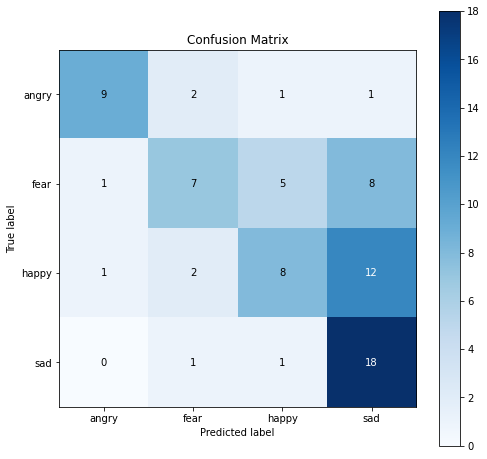

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))

# Tempogram + basic model

In [ ]:
audio_duration = 3
sampling_rate = 22050
input_length = sampling_rate * audio_duration

signal, sr = librosa.load('/content/drive/MyDrive/Colab Notebooks/SPEECH_EMOTION_Recognition/datasets/archive/Actor_02/03-01-02-02-01-01-02.wav')
if len(signal) > input_length:
  signal = signal[0:input_length]
elif  input_length > len(signal):
  max_offset = input_length - len(signal)  
  signal = np.pad(signal, (0, max_offset), "constant")
tempogram = librosa.feature.tempogram(signal, sr, win_length=100)

In [ ]:
tempogram = tempogram.T

In [ ]:
tempogram.shape

(130, 100)

In [ ]:
features = []
labels = []
for i in range(len(Ravdess_DF['Paths'])):
  if ((Ravdess_DF['Emotion'][i] == '03') | (Ravdess_DF['Emotion'][i] == '04') | 
      (Ravdess_DF['Emotion'][i] == '05') | (Ravdess_DF['Emotion'][i] == '06')):
    signal, sr = librosa.load(Ravdess_DF['Paths'][i])
    tempogram = np.mean(librosa.feature.tempogram(signal, sr).T, axis=0)
    features.append(tempogram)
    if Ravdess_DF['Emotion'][i] == '03':
      labels.append(0)
    elif Ravdess_DF['Emotion'][i] == '04':
      labels.append(1)
    elif Ravdess_DF['Emotion'][i] == '05':
      labels.append(2)
    elif Ravdess_DF['Emotion'][i] == '06':
      labels.append(3)


In [ ]:
X = features
y = labels

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

## basic models:

In [ ]:
model = Sequential()
model.add(Dense(384, input_shape=(384, ), activation = 'relu'))
#model.add(Dropout(0.1))
model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.25))
model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.2))
model.add(Dense(4, activation = 'softmax'))

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 384)               147840    
_________________________________________________________________
dense_28 (Dense)             (None, 128)               49280     
_________________________________________________________________
dense_29 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_30 (Dense)             (None, 4)                 516       
Total params: 214,148
Trainable params: 214,148
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, batch_size=64, epochs=200, 
                    validation_data=(X_val, y_val))

Epoch 1/200
10/10 [==============================] - 1s 31ms/step - loss: 1.3947 - accuracy: 0.2082 - val_loss: 1.3959 - val_accuracy: 0.1714
Epoch 2/200
10/10 [==============================] - 0s 4ms/step - loss: 1.3718 - accuracy: 0.3334 - val_loss: 1.3828 - val_accuracy: 0.2286
Epoch 3/200
10/10 [==============================] - 0s 4ms/step - loss: 1.3539 - accuracy: 0.3023 - val_loss: 1.4426 - val_accuracy: 0.2714
Epoch 4/200
10/10 [==============================] - 0s 4ms/step - loss: 1.3408 - accuracy: 0.3508 - val_loss: 1.3802 - val_accuracy: 0.3571
Epoch 5/200
10/10 [==============================] - 0s 5ms/step - loss: 1.3407 - accuracy: 0.3533 - val_loss: 1.3834 - val_accuracy: 0.3000
Epoch 6/200
10/10 [==============================] - 0s 5ms/step - loss: 1.3238 - accuracy: 0.3917 - val_loss: 1.3618 - val_accuracy: 0.3714
Epoch 7/200
10/10 [==============================] - 0s 4ms/step - loss: 1.3252 - accuracy: 0.3984 - val_loss: 1.3951 - val_accuracy: 0.3000
Epoch 8/200


In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/SPEECH_EMOTION_Recognition/Nộp bài(chốt hạ)/model_saver/basic_tempogram_ravdess.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.42      0.62      0.50        13
        fear       0.38      0.52      0.44        21
       happy       0.39      0.30      0.34        23
         sad       0.64      0.35      0.45        20

    accuracy                           0.43        77
   macro avg       0.46      0.45      0.43        77
weighted avg       0.46      0.43      0.42        77



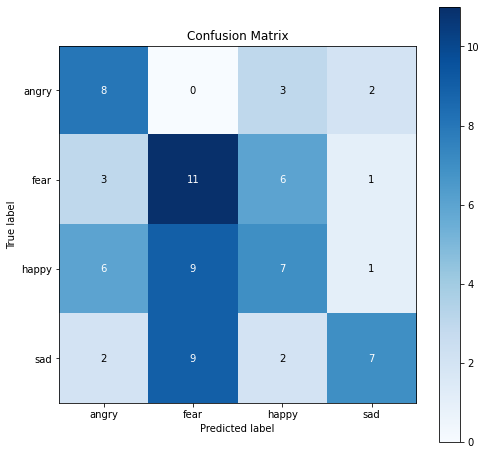

In [ ]:
skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))

# Tempogram + conv1D

In [ ]:
features = []
labels = []
for i in range(len(Ravdess_DF['Paths'])):
  if ((Ravdess_DF['Emotion'][i] == '03') | (Ravdess_DF['Emotion'][i] == '04') | 
      (Ravdess_DF['Emotion'][i] == '05') | (Ravdess_DF['Emotion'][i] == '06')):
    
    signal, sr = librosa.load(Ravdess_DF['Paths'][i])
    if len(signal) > input_length:
        signal = signal[0:input_length]
    elif  input_length > len(signal):
        max_offset = input_length - len(signal)  
        signal = np.pad(signal, (0, max_offset), "constant")
    tempogram = librosa.feature.tempogram(signal, sr)
    features.append(tempogram)
    if Ravdess_DF['Emotion'][i] == '03':
      labels.append(0)
    elif Ravdess_DF['Emotion'][i] == '04':
      labels.append(1)
    elif Ravdess_DF['Emotion'][i] == '05':
      labels.append(2)
    elif Ravdess_DF['Emotion'][i] == '06':
      labels.append(3)


In [ ]:
X = features
y = labels

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((621, 384, 259), (77, 384, 259), (621, 4), (77, 4))

### conv1D

In [ ]:

# CNN I/P Config
num_classes = 4
input_shape = X_train.shape[1:]
learning_rate = 0.0001
decay = 1e-6
momentum = 0.9

#LSTM Configuration
num_lstm = 256

In [ ]:
model = Sequential(name='Audio_CNN_1D')

# LFLB1
model.add(Conv1D(filters=64, kernel_size=(3), strides=1, padding='same', data_format='channels_last',input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.5))

# LFLB2
model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LFLB3
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LFLB4
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LSTM
model.add(LSTM(units=num_lstm))

# FC
model.add(Dense(units=num_classes, activation='softmax'))

# Model compilation
opt= keras.optimizers.Adam(lr=0.01, beta_1=0.9,  beta_2=0.999, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()


Model: "Audio_CNN_1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 384, 64)           49792     
_________________________________________________________________
batch_normalization_18 (Batc (None, 384, 64)           256       
_________________________________________________________________
activation_18 (Activation)   (None, 384, 64)           0         
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 96, 64)            0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 96, 64)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 96, 64)            12352     
_________________________________________________________________
batch_normalization_19 (Batc (None, 96, 64)           

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#Train Config

batch_size = 16
num_epochs = 200

# Model Training
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('/content/Audio_1DCNN.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')
cnnhistory=model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs,validation_data=(X_val, y_val), callbacks=[mcp_save, lr_reduce])

Epoch 1/200
39/39 [==============================] - 6s 42ms/step - loss: 1.5590 - categorical_accuracy: 0.2156 - val_loss: 1.4084 - val_categorical_accuracy: 0.1857
Epoch 2/200
39/39 [==============================] - 0s 12ms/step - loss: 1.3978 - categorical_accuracy: 0.2334 - val_loss: 1.3876 - val_categorical_accuracy: 0.1857
Epoch 3/200
39/39 [==============================] - 0s 12ms/step - loss: 1.3916 - categorical_accuracy: 0.2618 - val_loss: 1.3675 - val_categorical_accuracy: 0.3143
Epoch 4/200
39/39 [==============================] - 0s 13ms/step - loss: 1.4079 - categorical_accuracy: 0.2614 - val_loss: 1.3751 - val_categorical_accuracy: 0.2857
Epoch 5/200
39/39 [==============================] - 0s 12ms/step - loss: 1.3902 - categorical_accuracy: 0.2686 - val_loss: 1.3652 - val_categorical_accuracy: 0.3143
Epoch 6/200
39/39 [==============================] - 0s 12ms/step - loss: 1.3892 - categorical_accuracy: 0.2317 - val_loss: 1.3902 - val_categorical_accuracy: 0.2143
Epoc

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/SPEECH_EMOTION_Recognition/Nộp bài(chốt hạ)/model_saver/conv1D_tempogram_ravdess.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.56      0.38      0.45        13
        fear       0.36      0.57      0.44        21
       happy       0.29      0.09      0.13        23
         sad       0.43      0.60      0.50        20

    accuracy                           0.40        77
   macro avg       0.41      0.41      0.38        77
weighted avg       0.39      0.40      0.37        77



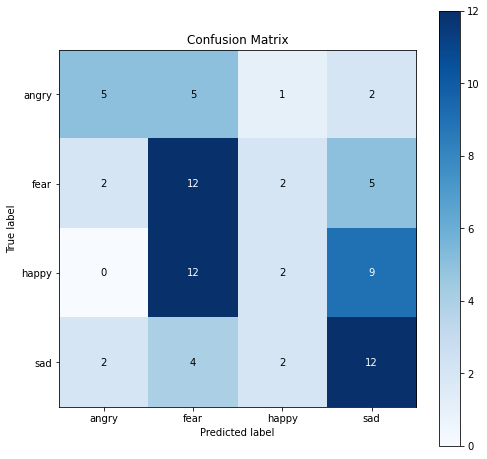

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))

# Tempogram + conv2D

In [ ]:
features = []
labels = []
for i in range(len(Ravdess_DF['Paths'])):
  if ((Ravdess_DF['Emotion'][i] == '03') | (Ravdess_DF['Emotion'][i] == '04') | 
      (Ravdess_DF['Emotion'][i] == '05') | (Ravdess_DF['Emotion'][i] == '06')):
    
    signal, sr = librosa.load(Ravdess_DF['Paths'][i])
    if len(signal) > input_length:
        signal = signal[0:input_length]
    elif  input_length > len(signal):
        max_offset = input_length - len(signal)  
        signal = np.pad(signal, (0, max_offset), "constant")
    tempogram = librosa.feature.tempogram(signal, sr)
    tempogram = np.expand_dims(tempogram, axis=-1)
    features.append(tempogram)
    if Ravdess_DF['Emotion'][i] == '03':
      labels.append(0)
    elif Ravdess_DF['Emotion'][i] == '04':
      labels.append(1)
    elif Ravdess_DF['Emotion'][i] == '05':
      labels.append(2)
    elif Ravdess_DF['Emotion'][i] == '06':
      labels.append(3)


In [ ]:
X = features
y = labels

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((621, 384, 259, 1), (77, 384, 259, 1), (621, 4), (77, 4))

### conv2D

In [ ]:
# CNN I/P Config
num_classes = 4
input_shape = X_train.shape[1:]
learning_rate = 0.0001
decay = 1e-6
momentum = 0.9

In [ ]:
model = Sequential(name='Audio_CNN_2D')

# LFLB1
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same',input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4,4), strides=(4,4)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(units=num_classes, activation='softmax'))

# Model compilation
opt = optimizers.SGD(lr=learning_rate, decay=decay, momentum=momentum, nesterov=True)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()

Model: "Audio_CNN_2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 384, 259, 64)      640       
_________________________________________________________________
batch_normalization_22 (Batc (None, 384, 259, 64)      256       
_________________________________________________________________
activation_22 (Activation)   (None, 384, 259, 64)      0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 192, 129, 64)      0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 192, 129, 64)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 192, 129, 64)      36928     
_________________________________________________________________
batch_normalization_23 (Batc (None, 192, 129, 64)     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#Train Config

batch_size = 16
num_epochs = 200

# Model Training
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('/content/Modelfull_2_1.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')
cnnhistory=model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs,validation_data=(X_val, y_val), callbacks=[mcp_save, lr_reduce])

Epoch 1/200
39/39 [==============================] - 7s 122ms/step - loss: 13.8097 - categorical_accuracy: 0.2308 - val_loss: 1.4164 - val_categorical_accuracy: 0.1857
Epoch 2/200
39/39 [==============================] - 3s 87ms/step - loss: 4.2879 - categorical_accuracy: 0.3322 - val_loss: 1.9323 - val_categorical_accuracy: 0.1857
Epoch 3/200
39/39 [==============================] - 3s 86ms/step - loss: 4.0681 - categorical_accuracy: 0.3206 - val_loss: 2.1488 - val_categorical_accuracy: 0.1857
Epoch 4/200
39/39 [==============================] - 3s 86ms/step - loss: 3.3103 - categorical_accuracy: 0.3460 - val_loss: 2.6095 - val_categorical_accuracy: 0.1857
Epoch 5/200
39/39 [==============================] - 3s 87ms/step - loss: 3.1421 - categorical_accuracy: 0.3314 - val_loss: 2.0948 - val_categorical_accuracy: 0.1857
Epoch 6/200
39/39 [==============================] - 3s 87ms/step - loss: 3.4386 - categorical_accuracy: 0.3424 - val_loss: 3.3177 - val_categorical_accuracy: 0.1857
Ep

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/SPEECH_EMOTION_Recognition/Nộp bài(chốt hạ)/model_saver/conv2D_tempogram_ravdess.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.50      0.08      0.13        13
        fear       0.40      0.38      0.39        21
       happy       0.00      0.00      0.00        23
         sad       0.35      0.90      0.50        20

    accuracy                           0.35        77
   macro avg       0.31      0.34      0.26        77
weighted avg       0.28      0.35      0.26        77



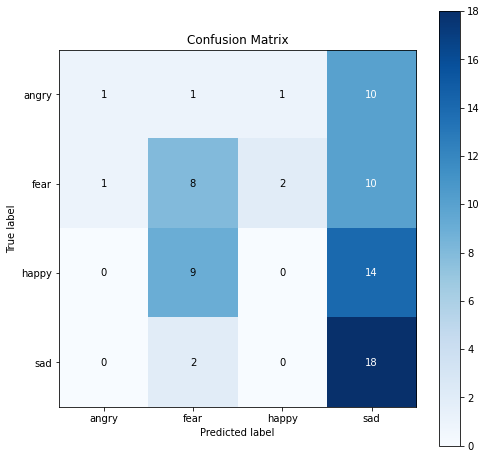

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))

# Combined feature + basic model

In [ ]:
signal, sr = librosa.load('/content/drive/MyDrive/Colab Notebooks/SPEECH_EMOTION_Recognition/datasets/archive/Actor_03/03-01-01-01-02-01-03.wav')


In [ ]:
mfcc = np.mean(librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=39).T,axis=0)
mel_spec = np.mean(librosa.feature.melspectrogram(signal, sr, n_mels=28).T, axis=0)
tempogram = np.mean(librosa.feature.tempogram(signal, sr, win_length=24).T, axis=0)

In [ ]:
mfcc = pd.DataFrame(mfcc)
mel_spec = pd.DataFrame(mel_spec)
tempogram = pd.DataFrame(tempogram)

In [ ]:
a = mfcc.append(mel_spec).append(tempogram)

In [ ]:
np.array(a[0]).shape

(91,)

In [ ]:
features = []
labels = []
for i in range(len(Ravdess_DF['Paths'])):
  if ((Ravdess_DF['Emotion'][i] == '03') | (Ravdess_DF['Emotion'][i] == '04') | 
      (Ravdess_DF['Emotion'][i] == '05') | (Ravdess_DF['Emotion'][i] == '06')):
    signal, sr = librosa.load(Ravdess_DF['Paths'][i])
    if len(signal) > input_length:
        signal = signal[0:input_length]
    elif  input_length > len(signal):
        max_offset = input_length - len(signal)  
        signal = np.pad(signal, (0, max_offset), "constant")
    mfcc = np.mean(librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=39).T,axis=0)
    mel_spec = np.mean(librosa.feature.melspectrogram(signal, sr, n_mels=28).T, axis=0)
    tempogram = np.mean(librosa.feature.tempogram(signal, sr, win_length=24).T, axis=0)

    mfcc = pd.DataFrame(mfcc)
    mel_spec = pd.DataFrame(mel_spec)
    tempogram = pd.DataFrame(tempogram)
    feature = mfcc.append(mel_spec).append(tempogram)
    feature = np.array(feature[0])
    features.append(feature)
    if Ravdess_DF['Emotion'][i] == '03':
      labels.append(0)
    elif Ravdess_DF['Emotion'][i] == '04':
      labels.append(1)
    elif Ravdess_DF['Emotion'][i] == '05':
      labels.append(2)
    elif Ravdess_DF['Emotion'][i] == '06':
      labels.append(3)


In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
features = sc.fit_transform(features)

In [ ]:
X = features
y = labels

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [ ]:
X_train.shape

(621, 91)

## basic models:

In [ ]:
model = Sequential()
model.add(Dense(91, input_shape=(91, ), activation = 'relu'))
#model.add(Dropout(0.1))
model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.25))
model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.2))
model.add(Dense(4, activation = 'softmax'))

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 91)                8372      
_________________________________________________________________
dense_34 (Dense)             (None, 128)               11776     
_________________________________________________________________
dense_35 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_36 (Dense)             (None, 4)                 516       
Total params: 37,176
Trainable params: 37,176
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, batch_size=64, epochs=200, 
                    validation_data=(X_val, y_val))

Epoch 1/200
10/10 [==============================] - 1s 35ms/step - loss: 1.3870 - accuracy: 0.2791 - val_loss: 1.2473 - val_accuracy: 0.4429
Epoch 2/200
10/10 [==============================] - 0s 4ms/step - loss: 1.1523 - accuracy: 0.5117 - val_loss: 1.2327 - val_accuracy: 0.4429
Epoch 3/200
10/10 [==============================] - 0s 4ms/step - loss: 1.0308 - accuracy: 0.5462 - val_loss: 1.1705 - val_accuracy: 0.5000
Epoch 4/200
10/10 [==============================] - 0s 4ms/step - loss: 0.9137 - accuracy: 0.6341 - val_loss: 1.1354 - val_accuracy: 0.5000
Epoch 5/200
10/10 [==============================] - 0s 4ms/step - loss: 0.8272 - accuracy: 0.6762 - val_loss: 1.0916 - val_accuracy: 0.5429
Epoch 6/200
10/10 [==============================] - 0s 4ms/step - loss: 0.6991 - accuracy: 0.7601 - val_loss: 1.0475 - val_accuracy: 0.5429
Epoch 7/200
10/10 [==============================] - 0s 4ms/step - loss: 0.6535 - accuracy: 0.7772 - val_loss: 0.9789 - val_accuracy: 0.6000
Epoch 8/200


In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/SPEECH_EMOTION_Recognition/Nộp bài(chốt hạ)/model_saver/basic_combined_ravdess.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       1.00      0.92      0.96        13
        fear       0.62      0.62      0.62        21
       happy       0.75      0.65      0.70        23
         sad       0.62      0.75      0.68        20

    accuracy                           0.71        77
   macro avg       0.75      0.74      0.74        77
weighted avg       0.72      0.71      0.72        77



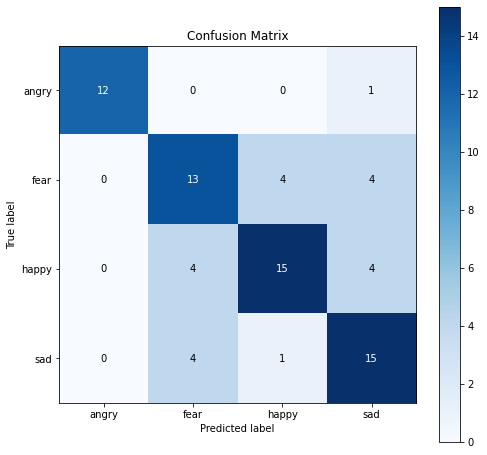

In [ ]:
skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))